In [42]:
"""Dataset modules for loading HDF5 simulation trajectories."""

import bisect
import json
import os
import os.path as osp
import re
import zipfile
from typing import Callable, Optional

import h5py
import jax.numpy as jnp
import numpy as np
import wget
from torch.utils.data import Dataset

from lagrangebench.utils import NodeType

In [2]:
def get_dataset_name_from_path(path: str) -> str:
    """Infer the dataset name from the provided path.

    This function assumes that the dataset directory name has the following structure:
    {2D|3D}_{TGV|RPF|LDC|DAM}_{num_particles_max}_{num_steps}every{sampling_rate}

    The dataset name then becomes one of the following:
    {tgv2d|tgv3d|rpf2d|rpf3d|ldc2d|ldc3d|dam2d}
    """

    name = re.search(r"(?:2D|3D)_[A-Z]{2}", path)
    assert name is not None, (
        f"No valid dataset name found in path {path}. "
        "Valid name formats: {2D|3D}_{HT|TGV|RPF|LDC|DAM} "
        "Alternatively, you can specify the dataset name explicitly."
    )
    name = name.group(0)
    name = f"{name.split('_')[1]}{name.split('_')[0]}".lower()
    return name

In [3]:
class H6Dataset(Dataset):
    """Dataset for loading HDF5 simulation trajectories.

    Reference on parallel loading of h5 samples see:
    https://github.com/pytorch/pytorch/issues/11929

    Implementation inspired by:
    https://github.com/Open-Catalyst-Project/ocp/blob/main/ocpmodels/datasets/lmdb_dataset.py
    """

    def __init__(
        self,
        split: str,
        dataset_path: str,
        name: Optional[str] = None,
        input_seq_length: int = 6,
        extra_seq_length: int = 0,
        nl_backend: str = "jaxmd_vmap",
        external_force_fn: Optional[Callable] = None,
    ):
        """Initialize the dataset. If the dataset is not present, it is downloaded.

        Args:
            split: "train", "valid", or "test"
            dataset_path: Path to the dataset
            name: Name of the dataset. If None, it is inferred from the path.
            input_seq_length: Length of the input sequence. The number of historic
                velocities is input_seq_length - 1. And during training, the returned
                number of past positions is input_seq_length + 1, to compute target
                acceleration.
            extra_seq_length: During training, this is the maximum number of pushforward
                unroll steps. During validation/testing, this specifies the largest
                N-step MSE loss we are interested in, e.g. for best model checkpointing.
            nl_backend: Which backend to use for the neighbor list
            external_force_fn: Function that returns the position-wise external force
        """

        if dataset_path.endswith("/"):  # remove trailing slash in dataset path
            dataset_path = dataset_path[:-1]

        if name is None:
            self.name = get_dataset_name_from_path(dataset_path)
        else:
            self.name = name
        if not osp.exists(dataset_path):
            dataset_path = self.download(self.name, dataset_path)

        assert split in ["train", "valid", "test"]
        assert (
            input_seq_length > 1
        ), "To compute at least one past velocity, input_seq_length must be >= 2."
        self.dataset_path = dataset_path
        self.file_path = osp.join(dataset_path, split + ".h5")
        self.input_seq_length = input_seq_length
        self.nl_backend = nl_backend

        self.external_force_fn = external_force_fn

        # load dataset metadata
        with open(osp.join(dataset_path, "metadata.json"), "r") as f:
            self.metadata = json.loads(f.read())

        self.db_hdf5 = None

        with h5py.File(self.file_path, "r") as f:
            self.traj_keys = list(f.keys())

            # (num_steps, num_particles, dim) = f["00000/position"].shape
            self.sequence_length = f["00000/position"].shape[0]

        if split == "train":
            # During training, the first input_seq_length steps can only be used as
            # input, and the last one to compute the target acceleration. If we use
            # pushforward, then we need to provide extra_seq_length more steps
            # from the end of a trajectory. Thus, the number of training samples per
            # trajectory becomes:
            self.subseq_length = input_seq_length + 1 + extra_seq_length
            samples_per_traj = self.sequence_length - self.subseq_length + 1

            keylens = jnp.array([samples_per_traj for _ in range(len(self.traj_keys))])
            self._keylen_cumulative = jnp.cumsum(keylens).tolist()

            self.num_samples = sum(keylens)
            self.getter = self.get_window

        else:
            assert (
                extra_seq_length > 0
            ), "extra_seq_length must be > 0 for validation and testing."
            # Compute the number of splits per validation trajectory. If the length of
            # each trajectory is 1000, we want to compute a 20-step MSE, and
            # intput_seq_length=6, then we should split the trajectory into
            # _split_valid_traj_into_n = 1000 // (20 + 6) chunks.
            self.subseq_length = input_seq_length + extra_seq_length
            self._split_valid_traj_into_n = self.sequence_length // self.subseq_length

            self.num_samples = self._split_valid_traj_into_n * len(self.traj_keys)
            self.getter = self.get_trajectory

        assert self.sequence_length >= self.subseq_length, (
            f"# steps in dataset trajectory ({self.sequence_length}) must be >= "
            f"subsequence length ({self.subseq_length}). Reduce either "
            f"input_seq_length or extra_seq_length/max pushforward steps."
        )

    def download(self, name: str, path: str) -> str:
        """Download the dataset.

        Args:
            name: Name of the dataset
            path: Destination path to the downloaded dataset
        """

        assert name in URLS, f"Dataset {name} not available."
        url = URLS[name]

        # path could be e.g. "./data/2D_TGV_2500_10kevery100/"
        # remove trailing slash if present and get the root of the datasets
        path = path[:-1] if path.endswith("/") else path
        path_root = osp.split(path)[0]  # e.g. # "./data"

        # download the dataset as a zip file, e.g. "./data/2D_TGV_2500_10kevery100.zip"
        os.makedirs(path_root, exist_ok=True)
        filename = wget.download(url, out=path_root)
        print(f"\nDataset {name} downloaded to {filename}")

        # unzip the dataset and then remove the zip file
        zipfile.ZipFile(filename, "r").extractall(path_root)
        os.remove(filename)

        return path

    def _open_hdf5(self) -> h5py.File:
        if self.db_hdf5 is None:
            return h5py.File(self.file_path, "r")
        else:
            return self.db_hdf5

    def _matscipy_pad(self, pos_input, particle_type, temp_input):
        padding_size = self.metadata["num_particles_max"] - pos_input.shape[0]
        pos_input = np.pad(
            pos_input,
            ((0, padding_size), (0, 0), (0, 0)),
            mode="constant",
            constant_values=0.0,
        )
        temp_input = np.pad(
            temp_input,
            (0, padding_size),
            mode="constant",
            constant_values=0.0,
        )
        particle_type = np.pad(
            particle_type,
            (0, padding_size),
            mode="constant",
            constant_values=NodeType.PAD_VALUE,
        )
        return pos_input, particle_type, temp_input

    def get_trajectory(self, idx: int):
        """Get a (full) trajectory and index idx."""
        # open the database file
        self.db_hdf5 = self._open_hdf5()

        if self._split_valid_traj_into_n > 1:
            traj_idx = idx // self._split_valid_traj_into_n
            slice_from = (idx % self._split_valid_traj_into_n) * self.subseq_length
            slice_to = slice_from + self.subseq_length
        else:
            traj_idx = idx
            slice_from = 0
            slice_to = self.sequence_length

        # get a pointer to the trajectory. That is not yet the real trajectory.
        traj = self.db_hdf5[f"{self.traj_keys[traj_idx]}"]
        # get a pointer to the positions of the traj. Still nothing in memory.
        traj_pos = traj["position"]
        # load and transpose the trajectory
        pos_input = traj_pos[slice_from:slice_to].transpose((1, 0, 2))
        particle_type = traj["particle_type"][:]

        traj_temp = traj["temperature"]
        temp_input = traj["temperature"][:]
        #temp_input = traj_temp[slice_from:slice_to].transpose((1, 0, 2))

        if self.nl_backend == "matscipy":
            pos_input, particle_type, temp_input = self._matscipy_pad(pos_input, particle_type, temp_input)

        return pos_input, particle_type, temp_input

    def get_window(self, idx: int):
        """Get a window of the trajectory and index idx."""
        # figure out which trajectory this should be indexed from.
        traj_idx = bisect.bisect(self._keylen_cumulative, idx)
        # extract index of element within that trajectory.
        el_idx = idx
        if traj_idx != 0:
            el_idx = idx - self._keylen_cumulative[traj_idx - 1]
        assert el_idx >= 0

        # open the database file
        self.db_hdf5 = self._open_hdf5()

        # get a pointer to the trajectory. That is not yet the real trajectory.
        traj = self.db_hdf5[f"{self.traj_keys[traj_idx]}"]
        # get a pointer to the positions of the traj. Still nothing in memory.
        traj_pos = traj["position"]
        # load only a slice of the positions. Now, this is an array in memory.
        pos_input_and_target = traj_pos[el_idx : el_idx + self.subseq_length]
        pos_input_and_target = pos_input_and_target.transpose((1, 0, 2))
        
        particle_type = traj["particle_type"][:]

        traj_temp = traj["temperature"]
        temp_input_and_target = traj["temperature"][:]
        #temp_input_and_target = traj_temp[el_idx : el_idx + self.subseq_length]
        #temp_input_and_target = temp_input_and_target.transpose((1, 0, 2))

        if self.nl_backend == "matscipy":
            pos_input_and_target, particle_type, temp_input_and_target = self._matscipy_pad(
                pos_input_and_target, particle_type, temp_input_and_target
            )

        return pos_input_and_target, particle_type, temp_input_and_target

    def __getitem__(self, idx: int):
        """
        Get a sequence of positions (of size windows) from the dataset at index idx.

        Returns:
            Array of shape (num_particles_max, input_seq_length + 1, dim). Along axis=1
                the position sequence (length input_seq_length) and the last position to
                compute the target acceleration.
        """
        return self.getter(idx)

    def __len__(self):
        return self.num_samples


In [4]:
class HT1D(H6Dataset):
    

    def __init__(
        self,
        split: str,
        dataset_path: str = "datasets/2D_HT_2500_10kevery100",
        input_seq_length: int = 6,
        extra_seq_length: int = 0,
        nl_backend: str = "jaxmd_vmap",
    ):
        super().__init__(
            split,
            dataset_path,
            name="ht2d",
            input_seq_length=input_seq_length,
            extra_seq_length=extra_seq_length,
            nl_backend=nl_backend,
        )

In [38]:
p="datasets/2D_HT_2500_10kevery100/valid.h5"
valid_seq_length = 6 + 20
with h5py.File(p, "r") as f:
        pos_shape =  f["00000/position"].shape
        temp_shape =  f["00000/temperature"].shape
        split_into = pos_shape[0]//valid_seq_length
        num_trajs = len(list(f.keys()))
        print(f"{p[9:]}, traj_shape= {str(pos_shape):<20}, "
              f"temp_shape= {str(temp_shape):<20},   "
              f"split_valid_traj_into_n= {split_into:<5}, "
              f"num_trajs: {num_trajs:<5}, "
              f"eval_n_trajs_infer: {split_into * num_trajs}")

2D_HT_2500_10kevery100/valid.h5, traj_shape= (61, 950, 2)        , temp_shape= (61, 950)           ,   split_valid_traj_into_n= 2    , num_trajs: 3    , eval_n_trajs_infer: 6


In [33]:
ht2d_train = HT1D("train", extra_seq_length=5)  # extra_seq_length=5 will be clear later
ht2d_valid = HT1D("valid", extra_seq_length=20)

print(
    f"This is a {ht2d_train.metadata['dim']}D dataset "
    f"called {ht2d_train.metadata['case']}.\n"
    f"Train snapshot have shape {ht2d_train[0][0].shape} (n_nodes, seq_len, xy pos).\n"
    f"Val snapshot have shape {ht2d_valid[0][0].shape} (n_nodes, rollout, xy pos).\n"
)

This is a 2D dataset called HT.
Train snapshot have shape (950, 12, 2) (n_nodes, seq_len, xy pos).
Val snapshot have shape (950, 26, 2) (n_nodes, rollout, xy pos).



In [36]:
ht2d_train[0][0][1]

array([[0.03, 0.01],
       [0.03, 0.01],
       [0.03, 0.01],
       [0.03, 0.01],
       [0.03, 0.01],
       [0.03, 0.01],
       [0.03, 0.01],
       [0.03, 0.01],
       [0.03, 0.01],
       [0.03, 0.01],
       [0.03, 0.01],
       [0.03, 0.01]], dtype=float32)

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_ENABLE_X64"] = "True"

import lagrangebench
import haiku as hk
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.animation as animation

In [10]:
def gns(x):
    return lagrangebench.GNS(
        particle_dimension=ht2d_train.metadata["dim"],
        latent_size=16,
        blocks_per_step=2,
        num_mp_steps=4,
        particle_type_embedding_size=8,
    )(x)

In [11]:
gns = hk.without_apply_rng(hk.transform_with_state(gns))

In [12]:
noise_std = 3e-4

pf_config = lagrangebench.PushforwardConfig(
    steps=[-1, 500, 700],  # training steps to unlock the relative stage
    unrolls=[0, 2, 5],  # number of unroll steps per stage
    probs=[7, 2, 1],  # relative probabilities to unroll to the relative stage
)

In [11]:
bounds = np.array(ht2d_train.metadata["bounds"])
box = bounds[:, 1] - bounds[:, 0]

ht2d_case = lagrangebench.case_builder(
    box=box,  # (x,y) array with the world size along each axis. (1.0, 1.0) for 2D TGV
    metadata=ht2d_train.metadata,  # metadata dictionary
    input_seq_length=6,  # number of consecutive time steps fed to the model
    isotropic_norm=False,  # whether to normalize each dimension independently
    noise_std=noise_std,  # noise standard deviation used by the random-walk noise
)

In [12]:
trainer = lagrangebench.Trainer(
    model=gns,
    case=ht2d_case,
    data_train=ht2d_train,
    data_valid=ht2d_valid,
    pushforward=pf_config,
    noise_std=noise_std,
    metrics=["mse"],
    n_rollout_steps=20,
    eval_n_trajs=1,
    lr_start=5e-4,
    log_steps=10,
    eval_steps=50,
    batch_size_infer=1,
)

params, state, _ = trainer(step_max=100)

/home/uppili11/.local/lib/python3.10/site-packages/lagrangebench/case_setup/case.py:153: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  pos_input = jnp.asarray(sample[0], dtype=dtype)
/home/uppili11/.local/lib/python3.10/site-packages/lagrangebench/case_setup/case.py:153: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  pos_input = jnp.asarray(sample[0], dtype=dtype)


000, train/loss: 6.41389.
010, train/loss: 2.01731.
020, train/loss: 2.34327.
030, train/loss: 1.88599.
040, train/loss: 1.88159.
050, train/loss: 1.81747.


/home/uppili11/.local/lib/python3.10/site-packages/lagrangebench/case_setup/case.py:153: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  pos_input = jnp.asarray(sample[0], dtype=dtype)


(eval) Reallocate neighbors list at step 14
(eval) From (2, 9480) to (2, 8935)
{'val/loss': 1.4451894458034076e-05, 'val/mse1': 1.707101482395501e-08, 'val/mse10': 2.1914888748142403e-06, 'val/mse5': 5.196682764108118e-07, 'val/stdloss': 0.0, 'val/stdmse1': 0.0, 'val/stdmse10': 0.0, 'val/stdmse5': 0.0}
060, train/loss: 1.78579.
070, train/loss: 1.71357.
080, train/loss: 1.73799.
090, train/loss: 1.57330.
100, train/loss: 1.55998.
{'val/loss': 1.263937429030193e-05, 'val/mse1': 1.8865939921397512e-08, 'val/mse10': 1.926938693941338e-06, 'val/mse5': 4.978853098691616e-07, 'val/stdloss': 0.0, 'val/stdmse1': 0.0, 'val/stdmse10': 0.0, 'val/stdmse5': 0.0}


In [28]:
ht2d_valid[5][2][0][400]

1.0122445

Text(0, 0.5, 'temp')

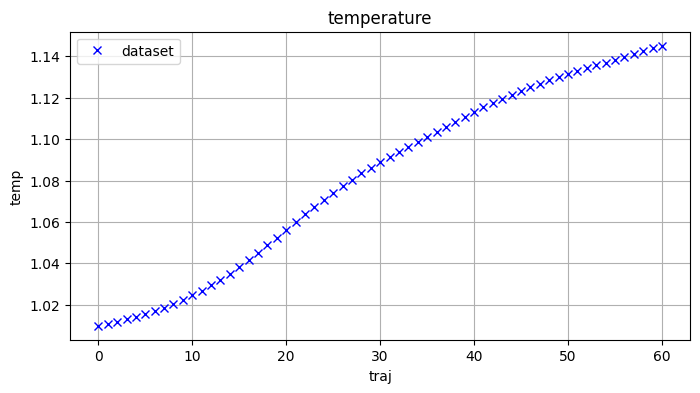

In [13]:
temp = []
for i in range (0,61):
    temp.append(ht2d_valid[0][2][i][400])

plt.figure(figsize=(8,4))
plt.plot(np.arange(0,5), temp, 'xb', label='dataset')
    
plt.legend() 
plt.grid()
plt.title("temperature")
plt.xlabel('traj')
plt.ylabel('temp')

Text(0, 0.5, 'temp')

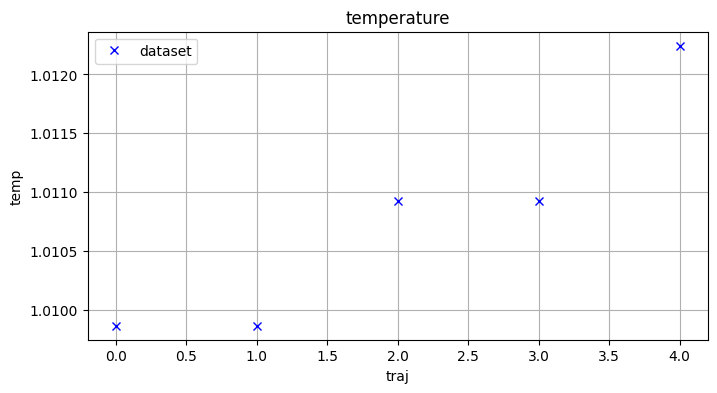

In [30]:
temp = []
for i in range (0, 5):
    temp.append(ht2d_valid[i][2][0][400])

plt.figure(figsize=(8,4))
plt.plot(np.arange(0,5), temp, 'xb', label='dataset')
    
plt.legend() 
plt.grid()
plt.title("temperature")
plt.xlabel('traj')
plt.ylabel('temp')